In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# -----------------------------
# Step 0 — load data
# -----------------------------
# Reason: explicit load so you inspect raw values before transformations.
df = pd.read_csv("C:\\Users\\aldom\\Msc Data Science\\Modules\\Module 5 - Machine learning and predictive analytics\\Assestemnt\\Cyber Attack Dataset_ ARP, SYN, PING Flood.csv")   # <-- replace with your filename or pass a DataFrame
print("Loaded dataframe shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

# Keep original labels in case we want multiclass later
if "label" in df.columns:
    df["label_orig"] = df["label"]

# -----------------------------
# Step 1 — collapse multiclass label to binary (0 = benign, 1 = attack)
# -----------------------------
# Reason: original labels include multiple attack types; for detection we convert all non-zero to attack.
label_col = "label"
assert label_col in df.columns, "label column not found"
df[label_col] = (df[label_col] != 0).astype(int)
print("Label distribution after mapping to binary:", np.unique(df[label_col], return_counts=True))

# -----------------------------
# Step 2 — basic inspection
# -----------------------------
# Reason: check value ranges, missingness, and peculiar encodings before transformations.
print(df.describe(include="all").T)
for c in ["arp.src.hw_mac", "arp.dst.hw_mac", "icmp.type"]:
    if c in df.columns:
        print(f"unique values for {c} (up to 20):", pd.unique(df[c])[:20])

# -----------------------------
# Step 3 — Drop MAC address features
# -----------------------------
# Reason: MACs are identifiers (often spoofed) and will cause memorization rather than generalization.
for mac_col in ["arp.src.hw_mac", "arp.dst.hw_mac"]:
    if mac_col in df.columns:
        df.drop(columns=[mac_col], inplace=True)
        print(f"dropped {mac_col}")

# -----------------------------
# Step 4 — Reconstruct TCP flag binaries
# -----------------------------
# Reason: flags should be binary {0,1} for interpretability and correct logistic behavior;
# your data shows standardized values — we recover flags with a robust heuristic.
flag_cols = [c for c in df.columns if c.startswith("tcp.flag_")]
print("flag columns found:", flag_cols)

def recover_binary_flag(series: pd.Series) -> pd.Series:
    """Map already-binary series to int; otherwise threshold at zero.
       This assumes standardization produced positive z-scores for values that were originally 1."""
    series_no_na = series.dropna()
    uniq = pd.unique(series_no_na)
    # If all unique values are subset of {0,1}, preserve them
    if set(uniq.tolist()).issubset({0, 1}):
        return series.fillna(0).astype(int)
    # Otherwise threshold at zero (positive -> 1, else 0)
    return (series > 0).astype(int)

for col in flag_cols:
    df[col] = recover_binary_flag(df[col])
    print(f"{col} -> unique values after recovery: {pd.unique(df[col])}")

# -----------------------------
# Step 5 — Handle icmp.type and other categorical-like columns
# -----------------------------
# Reason: treat ICMP type as categorical when it has multiple message types; otherwise binary.
icmp_is_categorical = False
if "icmp.type" in df.columns:
    icmp_nuniq = df["icmp.type"].nunique(dropna=True)
    print("icmp.type unique count:", icmp_nuniq)
    if icmp_nuniq <= 2:
        # Map to 0/1 safely
        df["icmp.type"] = df["icmp.type"].fillna(0).astype(int)
        icmp_is_categorical = False
    else:
        # Keep as string for one-hot encoding; fill NA with 'missing'
        df["icmp.type"] = df["icmp.type"].fillna("missing").astype(str)
        icmp_is_categorical = True

# -----------------------------
# Step 6 — Feature grouping
# -----------------------------
# Reason: build separate preprocessing branches for numeric / categorical / binary flags.
continuous_candidates = [c for c in ["frame.number", "frame.time_delta", "tcp.seq", "tcp.hdr_len", "data.len"] if c in df.columns]
binary_candidates = flag_cols.copy()
categorical_candidates = ["icmp.type"] if icmp_is_categorical else []

print("continuous:", continuous_candidates)
print("binary:", binary_candidates)
print("categorical:", categorical_candidates)

# -----------------------------
# Step 7 — Time-aware train/val/test split
# -----------------------------
# Reason: avoid temporal leakage. Prefer sorting by frame.number or timestamp.
if "frame.number" in df.columns:
    df_sorted = df.sort_values("frame.number").reset_index(drop=True)
    n = len(df_sorted)
    n_train = int(0.70 * n)
    n_val = int(0.15 * n)
    train_df = df_sorted.iloc[:n_train].reset_index(drop=True)
    val_df = df_sorted.iloc[n_train:n_train + n_val].reset_index(drop=True)
    test_df = df_sorted.iloc[n_train + n_val:].reset_index(drop=True)
    print(f"time-based split sizes: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")
else:
    # fallback: stratified split (less preferred)
    X = df.drop(columns=[label_col])
    y = df[label_col]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.30, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.50, random_state=42)
    train_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
    val_df = pd.concat([X_val.reset_index(drop=True), y_val.reset_index(drop=True)], axis=1)
    test_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
    print("Performed stratified random split (no frame.number present)")

# -----------------------------
# Step 8 — Build preprocessing pipelines (version-safe OneHotEncoder)
# -----------------------------
# Reason: ensure we use the correct parameter name for OneHotEncoder across sklearn versions.
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # median robust to outliers
    ("scaler", StandardScaler())                     # standardize for regularization & numeric stability
])

# OneHotEncoder param name changed in sklearn >= 1.2 ('sparse' -> 'sparse_output').
ohe_params = {"handle_unknown": "ignore"}
if sklearn.__version__ >= "1.2":
    ohe_params["sparse_output"] = False
else:
    ohe_params["sparse"] = False

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(**ohe_params))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, continuous_candidates),
        ("cat", categorical_transformer, categorical_candidates),
        ("bin", "passthrough", binary_candidates)
    ],
    remainder="drop"
)

# -----------------------------
# Step 9 — Build classifier pipeline (explicit multi_class)
# -----------------------------
# Reason: explicit 'ovr' for binary detection and class_weight to mitigate imbalance.
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(
        penalty="l2",
        solver="saga",
        multi_class="ovr",        # explicit and safe for binary detection
        class_weight="balanced",
        max_iter=500,
        random_state=42
    ))
])

# -----------------------------
# Step 10 — Fit pipeline on TRAIN and evaluate on VAL
# -----------------------------
X_train = train_df.drop(columns=[label_col])
y_train = train_df[label_col].astype(int)
X_val = val_df.drop(columns=[label_col])
y_val = val_df[label_col].astype(int)
X_test = test_df.drop(columns=[label_col])
y_test = test_df[label_col].astype(int)

print("Fitting pipeline on training data...")
clf.fit(X_train, y_train)

# Validation
y_val_pred = clf.predict(X_val)
y_val_proba = clf.predict_proba(X_val)[:, 1]
print("Validation classification report:")
print(classification_report(y_val, y_val_pred, digits=4))
print("Validation ROC AUC:", roc_auc_score(y_val, y_val_proba))

# -----------------------------
# Step 11 — Optional: hyperparameter tuning (time-aware CV)
# -----------------------------
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
}
tscv = TimeSeriesSplit(n_splits=4)
gscv = GridSearchCV(clf, param_grid, cv=tscv, scoring="f1", n_jobs=-1, verbose=1)
print("Running time-aware grid search...")
gscv.fit(X_train, y_train)

print("best params:", gscv.best_params_)
best_model = gscv.best_estimator_

# Evaluate best_model on test set
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]
print("Test classification report:")
print(classification_report(y_test, y_test_pred, digits=4))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_proba))

# -----------------------------
# Step 12 — Save pipeline
# -----------------------------
joblib.dump(best_model, "logreg_pipeline_dos.pkl")
print("Saved pipeline to logreg_pipeline_dos.pkl")

# -----------------------------
# Final notes (short)
# -----------------------------
# - If you have original unstandardized tcp.flag_* or raw binary flags, use them instead of the heuristic above.
# - If you want to retain attack-type classification (multiclass), revert the label mapping and use
#   LogisticRegression(multi_class='multinomial', solver='saga', ... ) and appropriate metrics.
# - For production, prefer a timestamp column for splitting rather than frame.number when available.


Loaded dataframe shape: (439171, 15)
Columns: ['frame.number', 'frame.time_delta', 'arp.src.hw_mac', 'arp.dst.hw_mac', 'arp.opcode', 'tcp.seq', 'tcp.hdr_len', 'data.len', 'icmp.type', 'tcp.flag_fin', 'tcp.flag_syn', 'tcp.flag_rst', 'tcp.flag_psh', 'tcp.flag_ack', 'label']


,frame.number,frame.time_delta,arp.src.hw_mac,arp.dst.hw_mac,arp.opcode,tcp.seq,tcp.hdr_len,data.len,icmp.type,tcp.flag_fin,tcp.flag_syn,tcp.flag_rst,tcp.flag_psh,tcp.flag_ack,label
0,-0.653301,-0.133379,0.108874,0.108519,-0.107299,-0.554036,0.054743,0.0,0.061314,-0.074391,-0.095219,-0.081841,2.056613,0.796384,0
1,0.881346,-0.132843,0.108874,0.108519,-0.107299,-0.546029,0.054743,0.0,0.061314,-0.074391,-0.095219,-0.081841,-0.486236,0.796384,0
2,-0.107629,-0.133766,0.108874,0.108519,-0.107299,-0.488997,0.054743,0.0,0.061314,-0.074391,-0.095219,-0.081841,-0.486236,0.796384,0
3,-1.236140,0.125851,0.108874,0.108519,-0.107299,-0.545796,0.054743,0.0,0.061314,-0.074391,-0.095219,-0.081841,-0.486236,0.796384,0
4,-1.341269,-0.132253,0.108874,0.108519,-0.107299,-0.508488,0.054743,0.0,0.061314,-0.074391,-0.095219,-0.081841,-0.486236,0.796384,0


Label distribution after mapping to binary: (array([0, 1]), array([431437,   7734]))
                     count          mean       std        min           25%  \
frame.number      439171.0  0.000000e+00  1.000001  -1.732047 -8.660234e-01   
frame.time_delta  439171.0  2.459236e-17  1.000001  -0.133785 -1.337661e-01   
arp.src.hw_mac    439171.0  1.251492e-15  1.000001 -15.809020  1.088737e-01   
arp.dst.hw_mac    439171.0  6.460024e-16  1.000001  -9.759288  1.085186e-01   
arp.opcode        439171.0  1.095007e-16  1.000001  -0.107299 -1.072993e-01   
tcp.seq           439171.0 -1.276214e-16  1.000001  -0.559552 -5.499076e-01   
tcp.hdr_len       439171.0  4.421641e-15  1.000001  -7.191937  4.290897e-15   
data.len          439171.0  1.100184e-17  1.000001  -1.125663  0.000000e+00   
icmp.type         439171.0  3.308966e-16  1.000001 -16.923859  6.131361e-02   
tcp.flag_fin      439171.0  9.448642e-17  1.000001  -0.074391 -7.439091e-02   
tcp.flag_syn      439171.0  1.235119e-16  1.00

c:\Users\aldom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\aldom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Validation classification report:
              precision    recall  f1-score   support

           0     0.9970    0.9995    0.9983     65602
           1     0.6964    0.2857    0.4052       273

    accuracy                         0.9965     65875
   macro avg     0.8467    0.6426    0.7017     65875
weighted avg     0.9958    0.9965    0.9958     65875

Validation ROC AUC: 0.9877085405575391
Running time-aware grid search...
Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\aldom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


best params: {'clf__C': 0.1, 'clf__penalty': 'l2'}
Test classification report:
              precision    recall  f1-score   support

           0     0.9977    0.9963    0.9970     63651
           1     0.8972    0.9331    0.9148      2226

    accuracy                         0.9941     65877
   macro avg     0.9474    0.9647    0.9559     65877
weighted avg     0.9943    0.9941    0.9942     65877

Test ROC AUC: 0.9990023158490771
Saved pipeline to logreg_pipeline_dos.pkl


c:\Users\aldom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


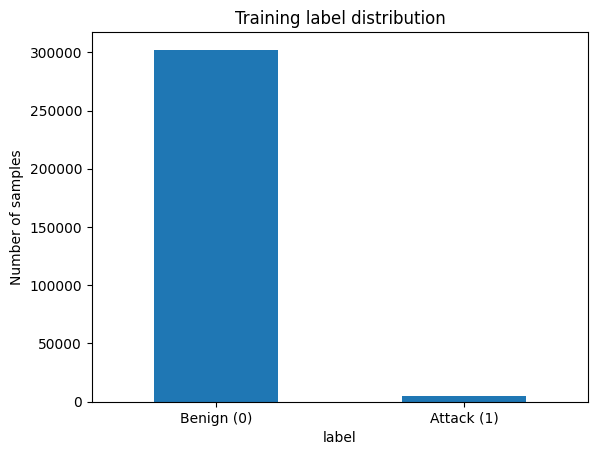

In [6]:
import matplotlib.pyplot as plt

counts = train_df["label"].value_counts().sort_index()
counts.plot(kind="bar")
plt.xticks([0,1], ["Benign (0)", "Attack (1)"], rotation=0)
plt.ylabel("Number of samples")
plt.title("Training label distribution")
plt.show()


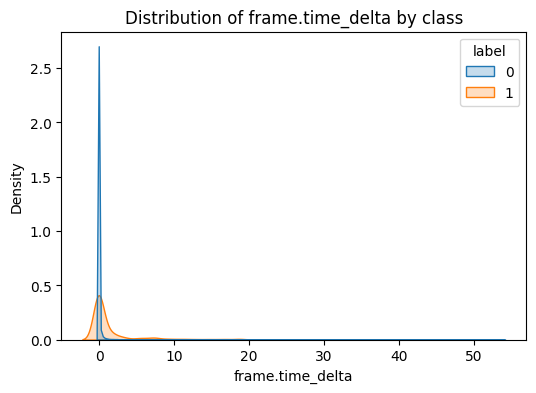

In [7]:
import seaborn as sns

feature = "frame.time_delta"  # change as needed

plt.figure(figsize=(6,4))
sns.kdeplot(
    data=train_df,
    x=feature,
    hue="label",
    common_norm=False,
    fill=True
)
plt.title(f"Distribution of {feature} by class")
plt.show()


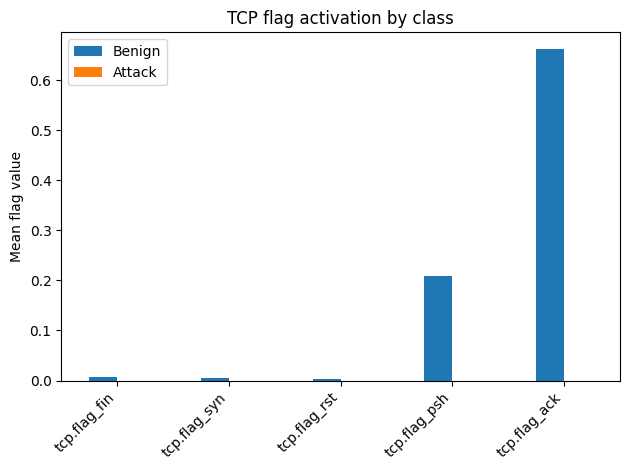

In [8]:
flag_means = (
    train_df
    .groupby("label")[flag_cols]
    .mean()
    .T
)

flag_means.plot(kind="bar")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean flag value")
plt.title("TCP flag activation by class")
plt.legend(["Benign", "Attack"])
plt.tight_layout()
plt.show()


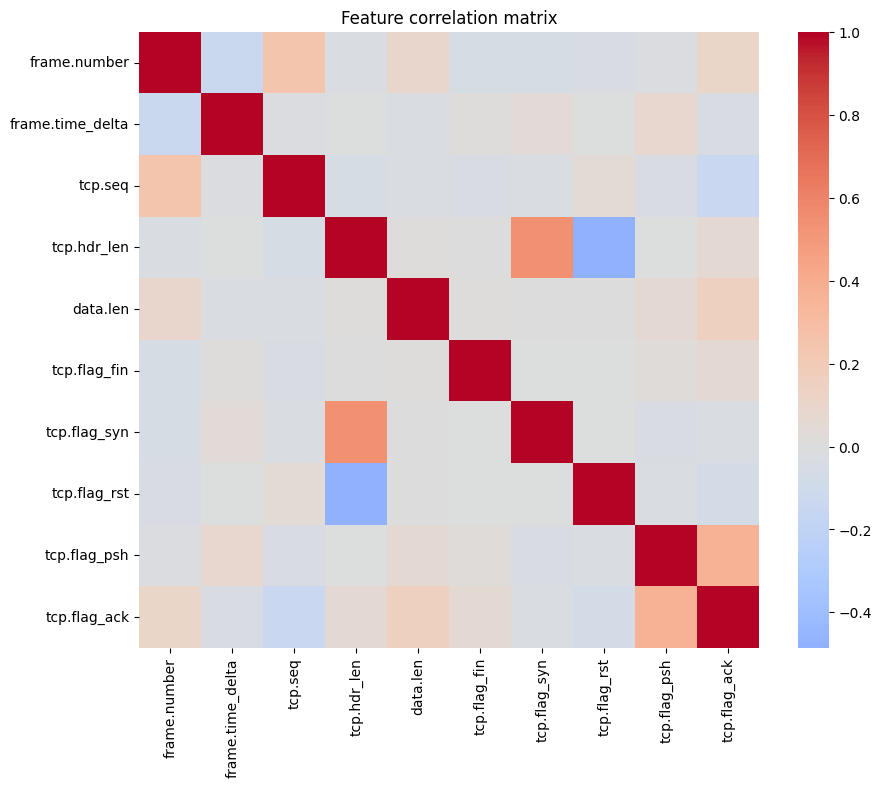

In [9]:
corr_features = continuous_candidates + binary_candidates
corr = train_df[corr_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature correlation matrix")
plt.show()


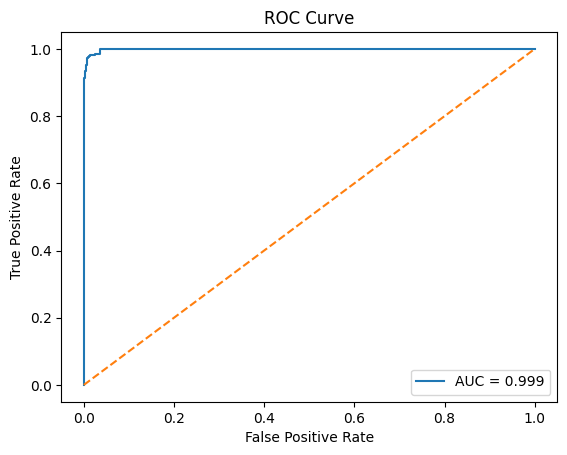

In [10]:
from sklearn.metrics import roc_curve, auc

y_score = best_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


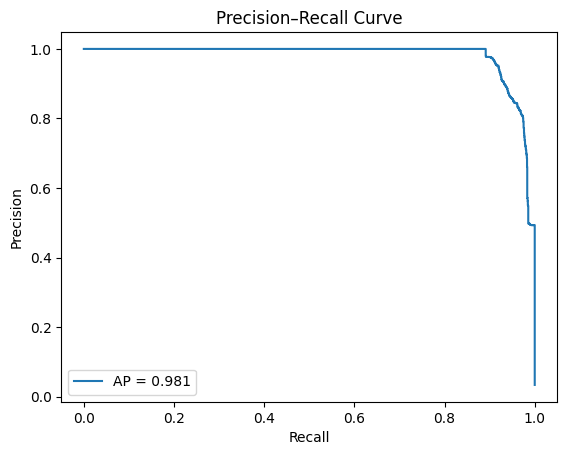

In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()


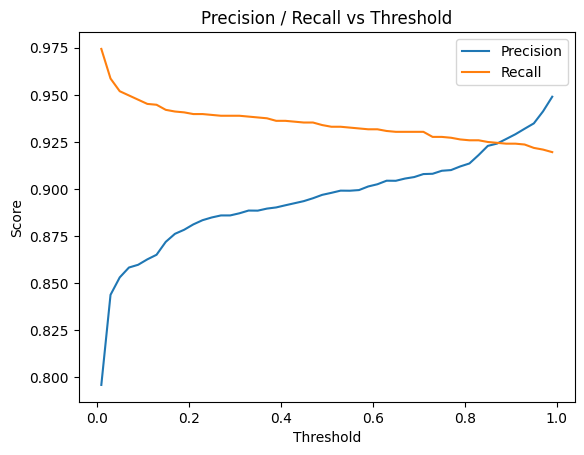

In [12]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0.01, 0.99, 50)
precisions, recalls = [], []

for t in thresholds:
    preds = (y_score >= t).astype(int)
    precisions.append(precision_score(y_test, preds))
    recalls.append(recall_score(y_test, preds))

plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall vs Threshold")
plt.legend()
plt.show()


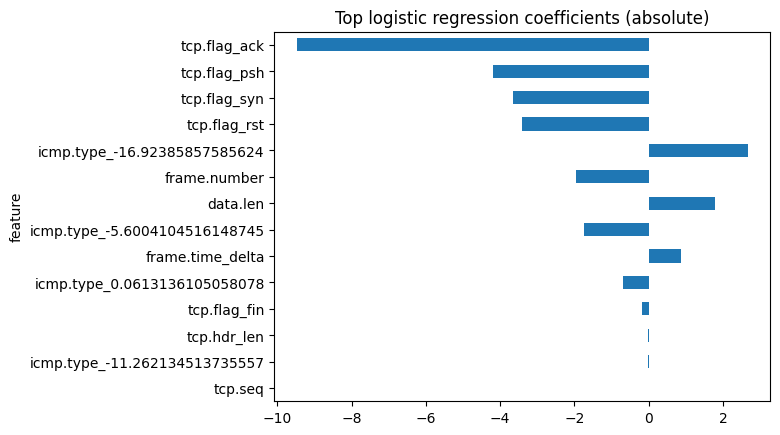

In [13]:
# Extract feature names after preprocessing
feature_names = (
    continuous_candidates
    + (
        list(best_model.named_steps["preprocessor"]
             .named_transformers_["cat"]
             .named_steps["onehot"]
             .get_feature_names_out(categorical_candidates))
        if categorical_candidates else []
    )
    + binary_candidates
)

coefs = best_model.named_steps["clf"].coef_[0]

coef_df = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
    .sort_values("coef", key=abs, ascending=False)
)

coef_df.head(15).plot(
    x="feature",
    y="coef",
    kind="barh",
    legend=False
)
plt.title("Top logistic regression coefficients (absolute)")
plt.gca().invert_yaxis()
plt.show()


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def visualize_time_based_split(df, train_df, val_df, test_df,
                               label_col=None,
                               time_col_candidates=('frame.number', 'timestamp'),
                               hist_bins=100,
                               rolling_window=50,
                               save_prefix=None,
                               figsize=(14, 8)):
    """
    Visualize time/frame-based dataset splits.

    Parameters
    ----------
    df : pd.DataFrame
        Original dataframe (optional but used to check coverage).
    train_df, val_df, test_df : pd.DataFrame
        DataFrames produced by the splitting logic.
    label_col : str or None
        If provided, show class distribution per split.
    time_col_candidates : tuple
        Fields to search for time/frame; first match will be used.
    hist_bins : int
        Bins to use for histogram / density plot.
    rolling_window : int
        Window size (in samples) for rolling count smoothing.
    save_prefix : str or None
        If provided, save figures to `{save_prefix}_*.png`.
    figsize : tuple
        Figure size for matplotlib.
    """
    # Find a time/frame column
    time_col = None
    for c in time_col_candidates:
        if c in df.columns:
            time_col = c
            break
    if time_col is None:
        raise ValueError(f"No time/frame column found in df. Looked for: {time_col_candidates}")

    # Prepare copy to avoid modifying user data
    def _prepare_time(series):
        s = series.copy()
        if np.issubdtype(s.dtype, np.number):
            return s.astype(float)
        # try to parse datetimes
        try:
            return pd.to_datetime(s)
        except Exception:
            raise ValueError(f"Time column {time_col} is neither numeric nor parseable datetime.")
    df_time = _prepare_time(df[time_col])
    t_train = _prepare_time(train_df[time_col])
    t_val = _prepare_time(val_df[time_col])
    t_test = _prepare_time(test_df[time_col])

    # Map to numeric axis for plotting if timestamps
    if np.issubdtype(df_time.dtype, np.datetime64):
        # convert to numeric (unix timestamp) for plotting; keep ticks readable
        df_num = df_time.view('int64') / 1e9  # seconds
        train_num = t_train.view('int64') / 1e9
        val_num = t_val.view('int64') / 1e9
        test_num = t_test.view('int64') / 1e9
        x_label = f"{time_col} (datetime)"
        tick_format_datetime = True
    else:
        df_num = df_time.astype(float)
        train_num = t_train.astype(float)
        val_num = t_val.astype(float)
        test_num = t_test.astype(float)
        x_label = f"{time_col}"
        tick_format_datetime = False

    # 1) Timeline scatter: sample index (in original order) vs time/frame
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    ax0 = axs[0,0]
    # For visual continuity, we will plot sample index vs time value.
    # Use index in the sorted-by-time df as y-axis to show ordering.
    sorted_df = df.copy()
    sorted_df = sorted_df.assign(_time=df_num).sort_values('_time').reset_index(drop=True)
    sample_idx = np.arange(len(sorted_df))
    # scatter the full dataset lightly
    ax0.scatter(sorted_df['_time'], sample_idx, s=4, alpha=0.15, label='all samples')
    # mark splits (use their times; map to same numeric scale)
    def _map_to_sorted_idx(times_numeric):
        # For each time value in split, find its position among sorted_df._time.
        # We use searchsorted for speed (works when sorted).
        arr = np.array(sorted_df['_time'])
        pos = np.searchsorted(arr, times_numeric)
        # clip to [0, n-1]
        pos = np.clip(pos, 0, len(arr)-1)
        return pos

    ax0.scatter(train_num, _map_to_sorted_idx(train_num), s=10, alpha=0.7, label='train')
    ax0.scatter(val_num, _map_to_sorted_idx(val_num), s=20, alpha=0.8, marker='D', label='val')
    ax0.scatter(test_num, _map_to_sorted_idx(test_num), s=10, alpha=0.7, marker='x', label='test')
    ax0.set_xlabel(x_label)
    ax0.set_ylabel('Sample index (sorted by time)')
    ax0.set_title('Timeline: samples colored by split')
    ax0.legend(loc='best')

    # format x-axis ticks to datetimes if present
    if tick_format_datetime:
        import matplotlib.dates as mdates
        ax0.xaxis_date()
        # convert seconds-since-epoch back to datetime
        def _sec_to_dt(x):
            return pd.to_datetime((x*1e9).astype('int64'))
        # set tick formatter
        ax0.xaxis.set_major_formatter(mdates.AutoDateFormatter(mdates.AutoDateLocator()))
        # convert plotted numbers back to datetimes for proper locator/formatter
        ax0.set_xlim(sorted_df['_time'].min(), sorted_df['_time'].max())

    # 2) Density / histogram along time axis
    ax1 = axs[0,1]
    # hist for each split (transparent, overlaid)
    ax1.hist(df_num, bins=hist_bins, alpha=0.25, label='all', density=False)
    ax1.hist(train_num, bins=hist_bins, alpha=0.6, label='train')
    ax1.hist(val_num, bins=hist_bins, alpha=0.7, label='val')
    ax1.hist(test_num, bins=hist_bins, alpha=0.6, label='test')
    ax1.set_xlabel(x_label)
    ax1.set_ylabel('Count')
    ax1.set_title('Sample density along time/frame axis')
    ax1.legend(loc='best')
    if tick_format_datetime:
        ax1.xaxis_date()
        ax1.xaxis.set_major_formatter(mdates.AutoDateFormatter(mdates.AutoDateLocator()))
        ax1.set_xlim(df_num.min(), df_num.max())

    # 3) Rolling count (smoothed) to highlight contiguous segments
    ax2 = axs[1,0]
    # create a boolean series over the global sorted index for each split
    s_train = np.zeros(len(sorted_df), dtype=int)
    s_val = np.zeros(len(sorted_df), dtype=int)
    s_test = np.zeros(len(sorted_df), dtype=int)
    # mark positions
    s_train[_map_to_sorted_idx(train_num)] = 1
    s_val[_map_to_sorted_idx(val_num)] = 1
    s_test[_map_to_sorted_idx(test_num)] = 1
    # rolling sum
    window = max(1, int(rolling_window))
    r_train = pd.Series(s_train).rolling(window, center=True, min_periods=1).sum()
    r_val = pd.Series(s_val).rolling(window, center=True, min_periods=1).sum()
    r_test = pd.Series(s_test).rolling(window, center=True, min_periods=1).sum()
    ax2.plot(sample_idx, r_train, label='train (rolling count)')
    ax2.plot(sample_idx, r_val, label='val (rolling count)')
    ax2.plot(sample_idx, r_test, label='test (rolling count)')
    ax2.set_xlabel('Sample index (sorted by time)')
    ax2.set_ylabel(f'Rolling count (window={window})')
    ax2.set_title('Smoothed contiguous coverage of splits')
    ax2.legend(loc='best')

    # 4) Class balance per split (if label_col provided)
    ax3 = axs[1,1]
    if label_col is None:
        ax3.axis('off')
        ax3.text(0.5, 0.5, 'No label_col provided\nClass-balance plot skipped',
                 ha='center', va='center', fontsize=12)
    else:
        # compute normalized counts for each split and plot grouped bars
        def _get_norm_counts(df_):
            counts = df_[label_col].value_counts().sort_index()
            return counts / counts.sum(), counts
        p_train, c_train = _get_norm_counts(train_df)
        p_val, c_val = _get_norm_counts(val_df)
        p_test, c_test = _get_norm_counts(test_df)
        # union of labels across splits (keeps order predictable)
        labels = sorted(set(p_train.index).union(p_val.index).union(p_test.index))
        x = np.arange(len(labels))
        width = 0.25
        # helper to get value or 0
        def _vals(p):
            return [p.get(lbl, 0.0) for lbl in labels]
        ax3.bar(x - width, _vals(p_train), width=width, label=f"train (n={len(train_df)})")
        ax3.bar(x, _vals(p_val), width=width, label=f"val (n={len(val_df)})")
        ax3.bar(x + width, _vals(p_test), width=width, label=f"test (n={len(test_df)})")
        ax3.set_xticks(x)
        ax3.set_xticklabels(labels, rotation=45, ha='right')
        ax3.set_ylabel('Proportion')
        ax3.set_title('Class proportion per split (normalized)')
        ax3.legend(loc='best')

    plt.tight_layout()
    if save_prefix:
        fig.savefig(f"{save_prefix}_split_summary.png", dpi=200, bbox_inches='tight')
    plt.show()

    # Summary printed
    print(f"Split sizes: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")
    if label_col:
        def _print_counts(name, df_):
            vc = df_[label_col].value_counts().to_dict()
            print(f"{name} class counts (n={len(df_)}): {vc}")
        _print_counts('train', train_df)
        _print_counts('val', val_df)
        _print_counts('test', test_df)

# Example usage:
# assume you already created train_df, val_df, test_df using your splitting snippet
# visualize_time_based_split(df, train_df, val_df, test_df, label_col='label', save_prefix='mydata')


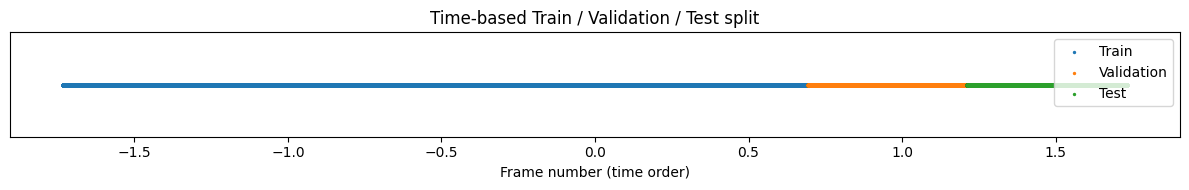

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 2))

plt.scatter(train_df["frame.number"], [1]*len(train_df),
            label="Train", s=2)
plt.scatter(val_df["frame.number"], [1]*len(val_df),
            label="Validation", s=2)
plt.scatter(test_df["frame.number"], [1]*len(test_df),
            label="Test", s=2)

plt.yticks([])
plt.xlabel("Frame number (time order)")
plt.title("Time-based Train / Validation / Test split")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


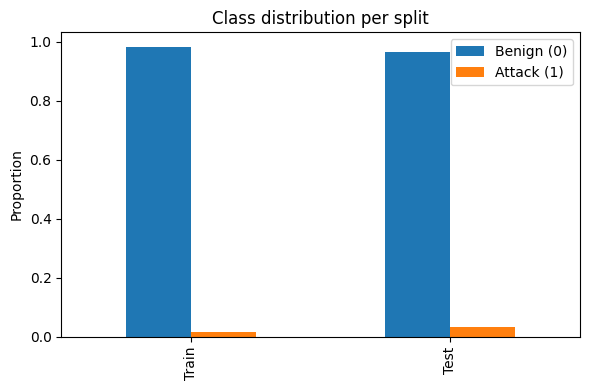

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))

splits = {
    "Train": train_df["label"],
    "Test": test_df["label"]
}

counts = {
    k: v.value_counts(normalize=True).sort_index()
    for k, v in splits.items()
}

pd.DataFrame(counts).T.plot(kind="bar", ax=ax)

ax.set_ylabel("Proportion")
ax.set_title("Class distribution per split")
ax.legend(["Benign (0)", "Attack (1)"])
plt.tight_layout()
plt.show()


In [5]:
# Create a copy of the full, sorted dataset
df_viz = df_sorted.copy() if "frame.number" in df.columns else df.copy()

# Initialize split label
df_viz["split"] = "unused"

# Assign splits by index ranges
df_viz.loc[train_df.index, "split"] = "train"
df_viz.loc[val_df.index, "split"] = "validation"
df_viz.loc[test_df.index, "split"] = "test"


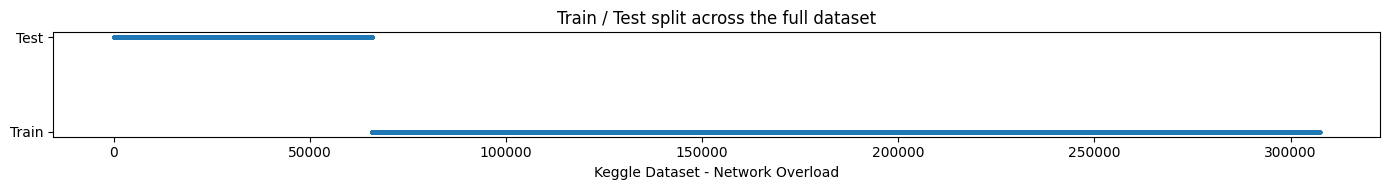

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 2))

split_map = {
    "train": 0,
    "test": 2
}

y = df_viz["split"].map(split_map)

plt.scatter(
    df_viz.index,
    y,
    s=2
)

plt.yticks(
    ticks=[0,2],
    labels=["Train","Test"]
)
plt.xlabel("Keggle Dataset - Network Overload")
plt.title("Train / Test split across the full dataset")
plt.tight_layout()
plt.show()


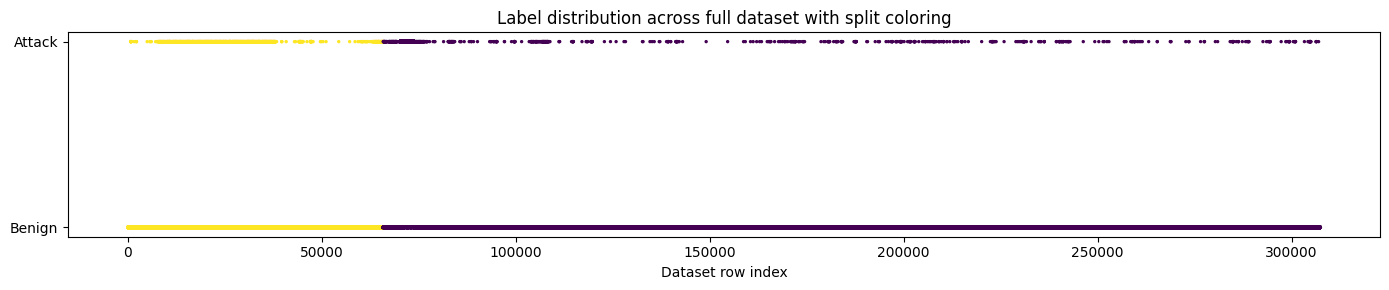

In [7]:
plt.figure(figsize=(14, 3))

plt.scatter(
    df_viz.index,
    df_viz["label"],
    c=y,
    s=2
)

plt.yticks([0, 1], ["Benign", "Attack"])
plt.xlabel("Dataset row index")
plt.title("Label distribution across full dataset with split coloring")
plt.tight_layout()
plt.show()


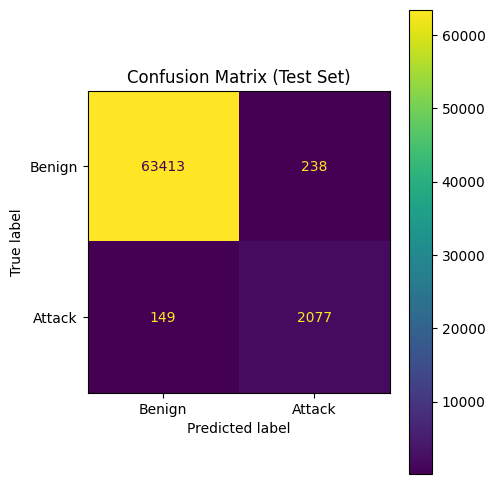

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Benign", "Attack"]
)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, values_format="d", cmap=None)
ax.set_title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


In [16]:
tn, fp, fn, tp = cm.ravel()

print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print(f"False Positive Rate (FPR): {fp / (fp + tn):.4f}")
print(f"False Negative Rate (FNR): {fn / (fn + tp):.4f}")


True Negatives (TN): 63413
False Positives (FP): 238
False Negatives (FN): 149
True Positives (TP): 2077
False Positive Rate (FPR): 0.0037
False Negative Rate (FNR): 0.0669


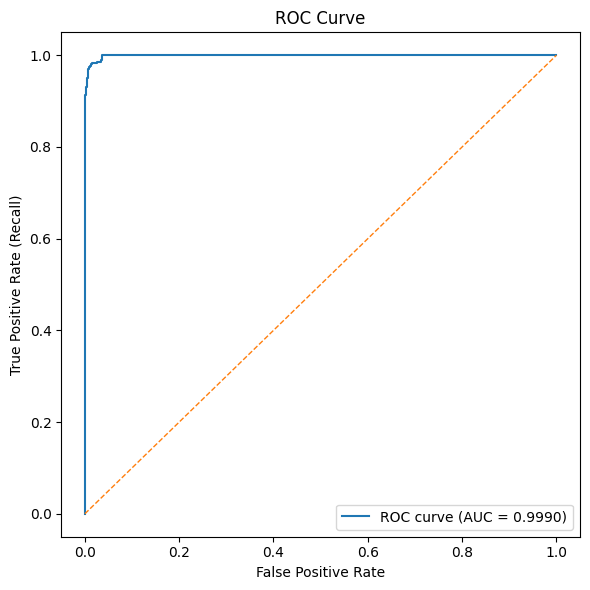

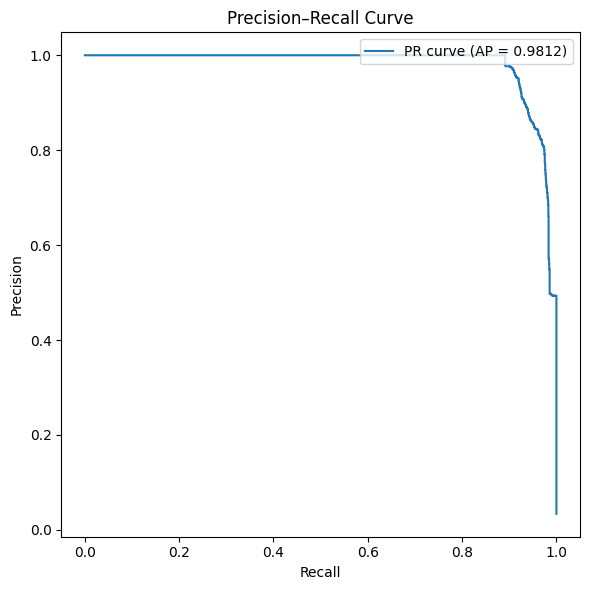

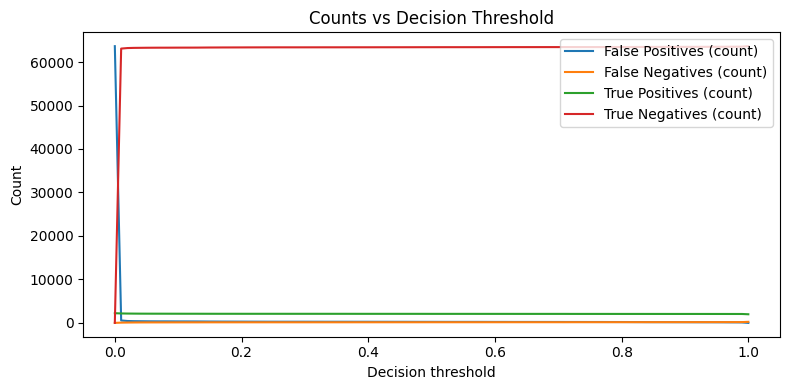

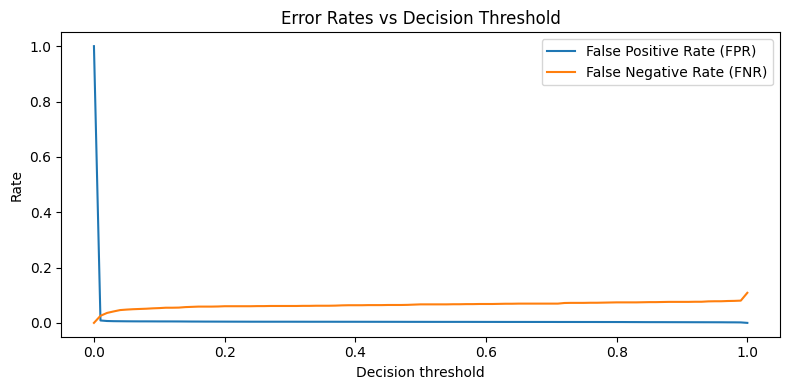

Threshold for FPR <= 0.010: 0.0097 with TPR=0.9753 and FPR=0.0090
Youden optimal threshold: 0.0061 (TPR=0.9825, FPR=0.0151)
Candidate thresholds to consider: [np.float64(0.00972338147175214), np.float64(0.006107843356632956)]


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix
)

# --- pick model variable robustly ---
model = globals().get("best_model", None) or globals().get("clf", None)
if model is None:
    raise RuntimeError("No fitted model found. Make sure best_model or clf exists.")

# --- get probabilities for positive class ---
if hasattr(model, "predict_proba"):
    y_score = model.predict_proba(X_test)[:, 1]
elif hasattr(model, "decision_function"):
    # decision_function may be unbounded; treat as score
    y_score = model.decision_function(X_test)
else:
    raise RuntimeError("Model has neither predict_proba nor decision_function.")

# --- ROC curve ---
fpr, tpr, roc_thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Precision-Recall curve ---
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_score)
avg_prec = average_precision_score(y_test, y_score)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f"PR curve (AP = {avg_prec:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="upper right")
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Threshold vs FP/FN trade-off ---
# Use evenly spaced thresholds between 0 and 1 (include extremes)
thresholds = np.linspace(0.0, 1.0, 101)
fp_counts = []
fn_counts = []
tn_counts = []
tp_counts = []

for thr in thresholds:
    y_pred_thr = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thr).ravel()
    fp_counts.append(fp)
    fn_counts.append(fn)
    tn_counts.append(tn)
    tp_counts.append(tp)

fp_counts = np.array(fp_counts)
fn_counts = np.array(fn_counts)
tp_counts = np.array(tp_counts)
tn_counts = np.array(tn_counts)
n_pos = (y_test == 1).sum()
n_neg = (y_test == 0).sum()

# Plot counts
plt.figure(figsize=(8, 4))
plt.plot(thresholds, fp_counts, label="False Positives (count)")
plt.plot(thresholds, fn_counts, label="False Negatives (count)")
plt.plot(thresholds, tp_counts, label="True Positives (count)")
plt.plot(thresholds, tn_counts, label="True Negatives (count)")
plt.xlabel("Decision threshold")
plt.ylabel("Count")
plt.title("Counts vs Decision Threshold")
plt.legend(loc="upper right")
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot rates (normalize by class counts) — FPR and FNR are most informative
fpr_rates = fp_counts / (fp_counts + tn_counts + 1e-12)   # = fp / n_neg
fnr_rates = fn_counts / (fn_counts + tp_counts + 1e-12)   # = fn / n_pos

plt.figure(figsize=(8, 4))
plt.plot(thresholds, fpr_rates, label="False Positive Rate (FPR)")
plt.plot(thresholds, fnr_rates, label="False Negative Rate (FNR)")
plt.xlabel("Decision threshold")
plt.ylabel("Rate")
plt.title("Error Rates vs Decision Threshold")
plt.legend(loc="upper right")
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Helpful operating-point helpers ---
# 1) threshold achieving target max FPR (example: <= 1%)
target_fpr = 0.01
eligible = np.where(fpr <= target_fpr)[0]
if eligible.size > 0:
    # pick threshold with largest TPR subject to FPR <= target
    idx = eligible[np.argmax(tpr[eligible])]
    thr_for_target_fpr = roc_thresholds[idx]
    print(f"Threshold for FPR <= {target_fpr:.3f}: {thr_for_target_fpr:.4f} "
          f"with TPR={tpr[idx]:.4f} and FPR={fpr[idx]:.4f}")
else:
    print(f"No threshold found with FPR <= {target_fpr:.3f}; consider relaxing target or improving model.")

# 2) threshold that maximizes Youden's J = TPR - FPR (balance point)
youden = tpr - fpr
idx_youden = np.argmax(youden)
thr_youden = roc_thresholds[idx_youden]
print(f"Youden optimal threshold: {thr_youden:.4f} (TPR={tpr[idx_youden]:.4f}, FPR={fpr[idx_youden]:.4f})")

# 3) show top candidate thresholds around interesting operating points
candidates = [thr_for_target_fpr if eligible.size > 0 else None, thr_youden]
print("Candidate thresholds to consider:", candidates)


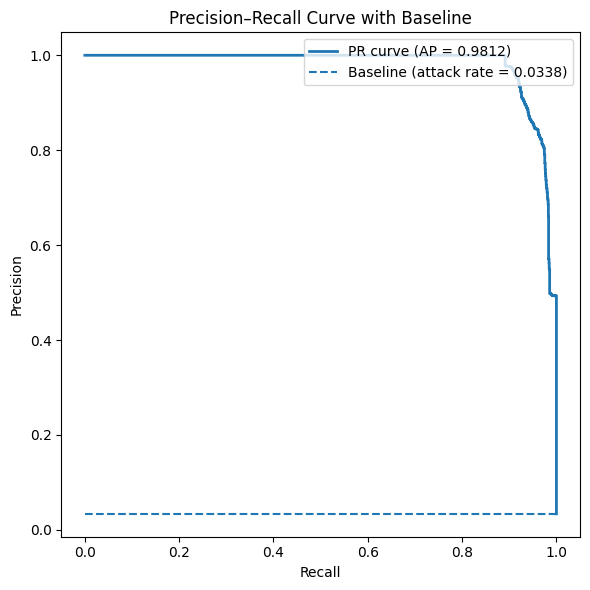

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute PR curve
precision, recall, _ = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

# Baseline precision = positive class prevalence
baseline = y_test.mean()

plt.figure(figsize=(6, 6))
plt.plot(
    recall,
    precision,
    label=f"PR curve (AP = {ap:.4f})",
    linewidth=2
)
plt.hlines(
    baseline,
    xmin=0,
    xmax=1,
    linestyles="dashed",
    label=f"Baseline (attack rate = {baseline:.4f})"
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve with Baseline")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


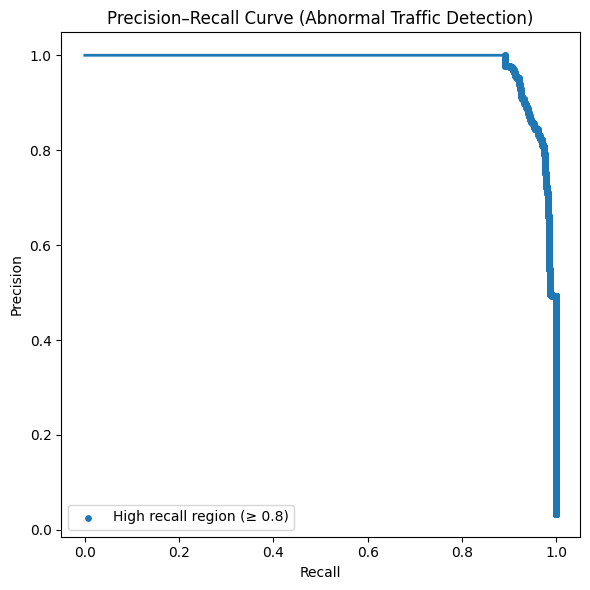

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Compute precision–recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, linewidth=2)

# Highlight high-recall region (e.g. recall >= 0.8)
high_recall_mask = recall >= 0.8
plt.scatter(
    recall[high_recall_mask],
    precision[high_recall_mask],
    s=15,
    label="High recall region (≥ 0.8)"
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Abnormal Traffic Detection)")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


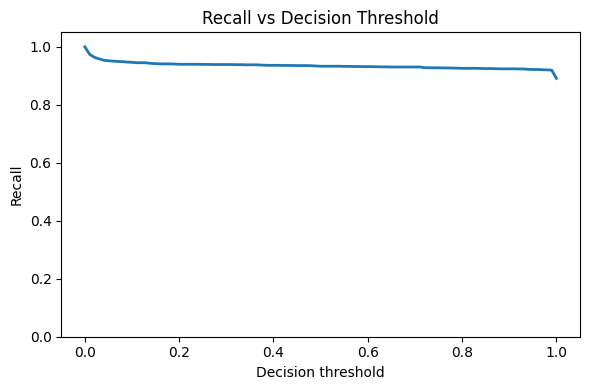

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# Compute recall across thresholds
thresholds = np.linspace(0.0, 1.0, 101)
recalls = []

for thr in thresholds:
    y_pred_thr = (y_score >= thr).astype(int)
    recalls.append(recall_score(y_test, y_pred_thr))

recalls = np.array(recalls)

plt.figure(figsize=(6, 4))
plt.plot(thresholds, recalls, linewidth=2)
plt.xlabel("Decision threshold")
plt.ylabel("Recall")
plt.title("Recall vs Decision Threshold")
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


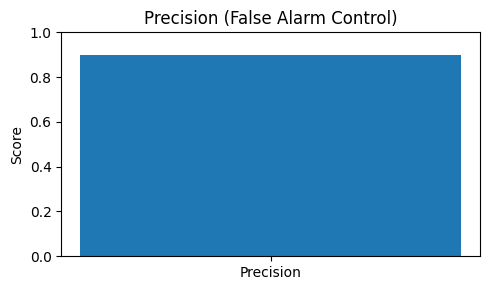

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score

precision_default = precision_score(y_test, y_test_pred)

plt.figure(figsize=(5, 3))
plt.bar(["Precision"], [precision_default])
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Precision (False Alarm Control)")
plt.tight_layout()
plt.show()


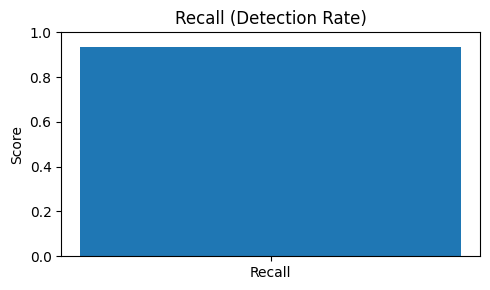

In [26]:
from sklearn.metrics import recall_score

recall_default = recall_score(y_test, y_test_pred)

plt.figure(figsize=(5, 3))
plt.bar(["Recall"], [recall_default])
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Recall (Detection Rate)")
plt.tight_layout()
plt.show()


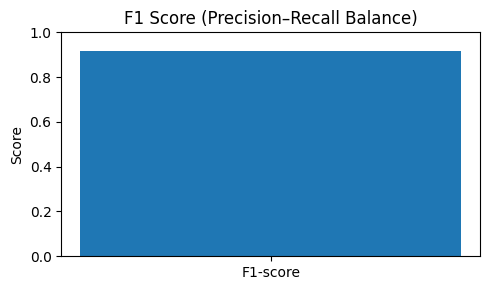

In [27]:
from sklearn.metrics import f1_score

f1_default = f1_score(y_test, y_test_pred)

plt.figure(figsize=(5, 3))
plt.bar(["F1-score"], [f1_default])
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("F1 Score (Precision–Recall Balance)")
plt.tight_layout()
plt.show()


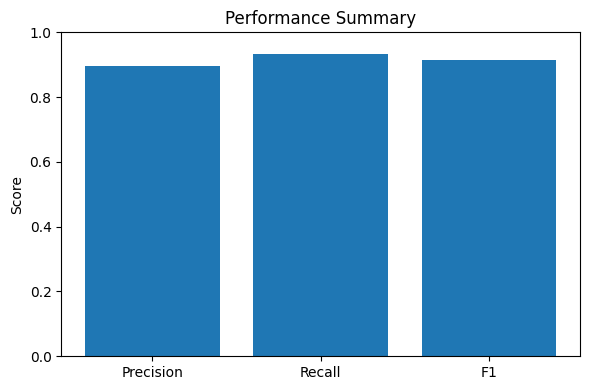

In [28]:
metrics = {
    "Precision": precision_default,
    "Recall": recall_default,
    "F1": f1_default
}

plt.figure(figsize=(6, 4))
plt.bar(metrics.keys(), metrics.values())
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Performance Summary")
plt.tight_layout()
plt.show()


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


Precision: 0.8972
Recall:    0.9331
F1-score:  0.9148


In [30]:
from sklearn.metrics import average_precision_score

pr_auc = average_precision_score(y_test, y_score)

print(f"Precision–Recall AUC (Average Precision): {pr_auc:.4f}")


Precision–Recall AUC (Average Precision): 0.9812


In [31]:
import numpy as np
import matplotlib.pyplot as plt

model = best_model if "best_model" in globals() else clf

feature_names = model.named_steps["preprocessor"].get_feature_names_out()


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

C_values = np.logspace(-3, 2, 15)  # from strong to weak regularization
coefs = []

for C in C_values:
    ridge_clf = Pipeline(steps=[
        ("preprocessor", model.named_steps["preprocessor"]),
        ("clf", LogisticRegression(
            penalty="l2",
            C=C,
            solver="saga",
            class_weight="balanced",
            max_iter=500,
            random_state=42
        ))
    ])
    ridge_clf.fit(X_train, y_train)
    coefs.append(ridge_clf.named_steps["clf"].coef_.ravel())

coefs = np.array(coefs)


c:\Users\aldom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aldom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aldom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aldom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aldom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

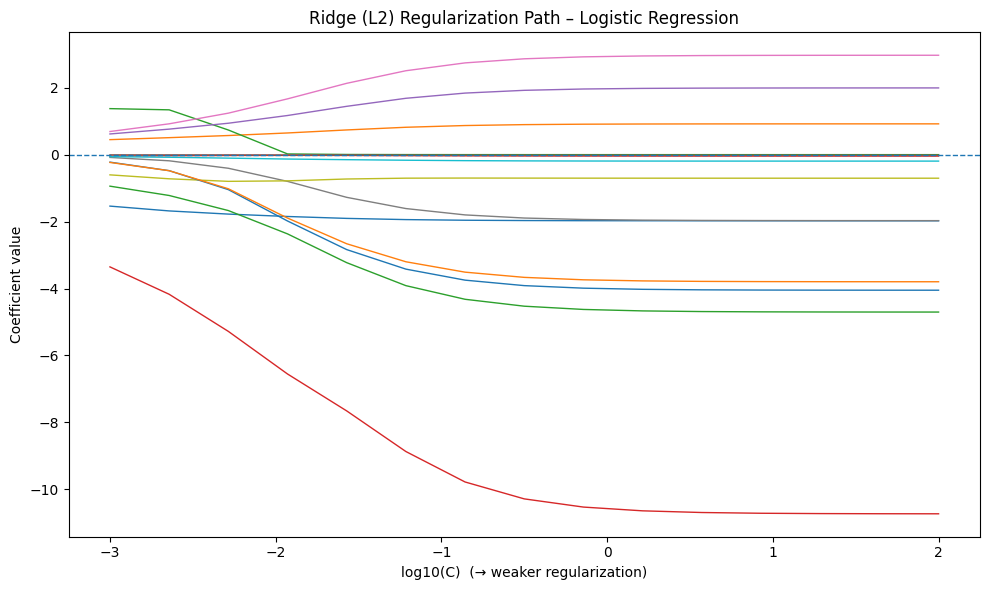

In [33]:
plt.figure(figsize=(10, 6))

for i in range(min(15, coefs.shape[1])):  # plot top 15 features for clarity
    plt.plot(
        np.log10(C_values),
        coefs[:, i],
        linewidth=1
    )

plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("log10(C)  (→ weaker regularization)")
plt.ylabel("Coefficient value")
plt.title("Ridge (L2) Regularization Path – Logistic Regression")
plt.tight_layout()
plt.show()


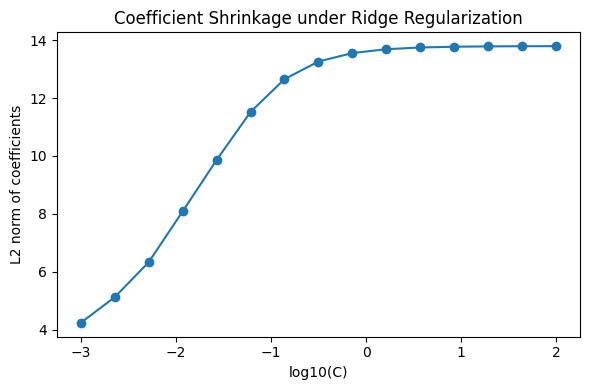

In [34]:
coef_norms = np.linalg.norm(coefs, axis=1)

plt.figure(figsize=(6, 4))
plt.plot(np.log10(C_values), coef_norms, marker="o")
plt.xlabel("log10(C)")
plt.ylabel("L2 norm of coefficients")
plt.title("Coefficient Shrinkage under Ridge Regularization")
plt.tight_layout()
plt.show()
